# Slope LOO vs Holdout on Same 100k

**Goal:** Compare slope AUC on the *same* 100k test set (batches 0–9) under two setups:
- **Slope LOO (pool-39):** Use existing slope LOO FULL.pt; evaluate AUC on first 100k only.
- **Slope holdout (pool-5):** Train params pooled from 5 batches (10–14), test on 0–9 → ~0.76.

**Interpretation:**
- If LOO-on-100k ≈ **0.76** (like holdout) → the higher LOO-on-400k (~0.85) is mostly **test-set size** (400k vs 100k).
- If LOO-on-100k ≈ **0.85** → on the same 100k, **pooling** (5 vs 39) matters; holdout is hurt by pool-5.

**Steps:**
1. Run slope LOO evaluation restricted to 100k (fast; no new predictions).
2. Optionally re-run holdout overnight (set `RUN_HOLDOUT = True`).
3. Load results and compare in a table + plot.

## Config

- `RUN_LOO_100K_EVAL`: run LOO-on-100k evaluation (recommended: True; takes a few minutes).
- `RUN_HOLDOUT`: re-run slope holdout (pool-5, test 0–9). Set True for overnight to refresh holdout results.

In [ ]:
import subprocess
import sys
from pathlib import Path

CLAUDE_DIR = Path('/Users/sarahurbut/aladynoulli2/claudefile')
RUN_LOO_100K_EVAL = True   # evaluate slope LOO on first 100k (fast)
RUN_HOLDOUT = True      # re-run slope holdout (slow; set True for overnight)
N_BOOTSTRAPS = 100

def run_cmd(cmd, description):
    print(f"\n{'='*60}")
    print(description)
    print(f"  {cmd}")
    print('='*60)
    if isinstance(cmd, str):
        subprocess.run(cmd, shell=True, cwd=str(CLAUDE_DIR))
    else:
        subprocess.run(cmd, cwd=str(CLAUDE_DIR))
    print()

## Step 1: Slope LOO on 100k

Loads existing `enrollment_predictions_slope_1phase_loo_all40/pi_enroll_fixedphi_sex_FULL.pt`, restricts to first 100k, runs same AUC evaluation. Writes to `results_slope_1phase_loo/*_100k.csv`.

In [ ]:
if RUN_LOO_100K_EVAL:
    run_cmd(
        [sys.executable, str(CLAUDE_DIR / 'run_slope_loo_100k_eval.py'), '--n_bootstraps', str(N_BOOTSTRAPS)],
        'Slope LOO AUC on first 100k (same test set as holdout)'
    )
else:
    print('Skipped (RUN_LOO_100K_EVAL=False). Set True to run.')

## Step 2: Optional — Re-run slope holdout (overnight)

Pool slope from 5 batches (10–14), fit delta on batches 0–9, save π and compute AUC. Use for a fresh holdout result; existing results in `results_holdout_auc/` are fine if you don't need to refresh.

To get **1-phase pool-30** (same 100k test set, 30 batches from 1-phase checkpoints): run `python slope_holdout_auc.py --single_phase --single_phase_wide`. Results → `holdout_auc_slope_1phase_pool30_vs_noslope.csv`; the comparison below will load them when present.

In [ ]:
if RUN_HOLDOUT:
    run_cmd(
        f"{sys.executable} slope_holdout_auc.py --single_phase --n_bootstraps {N_BOOTSTRAPS}",
        'Slope holdout (pool 5, test 0–9) — can take 1–2 hours'
    )
else:
    print('Skipped (RUN_HOLDOUT=False). Set True to re-run holdout overnight.')

## Step 3: Load results and compare

Load slope LOO 100k (static 10yr), slope holdout (static 10yr), no-slope holdout (static 10yr). Build comparison table.

In [ ]:
import pandas as pd
import numpy as np

RESULTS_LOO = CLAUDE_DIR / 'results_slope_1phase_loo'
RESULTS_HOLDOUT = CLAUDE_DIR / 'results_holdout_auc'

# Slope LOO on 100k (from Step 1)
loo_100k_path = RESULTS_LOO / 'static_10yr_results_100000.csv'
if not loo_100k_path.exists():
    raise FileNotFoundError(f'Run Step 1 first. Missing: {loo_100k_path}')

df_loo = pd.read_csv(loo_100k_path)
df_loo = df_loo.rename(columns={'Disease': 'disease', 'AUC': 'auc_slope_loo_100k',
                               'CI_lower': 'ci_lower_loo', 'CI_upper': 'ci_upper_loo'})
df_loo = df_loo[['disease', 'auc_slope_loo_100k', 'ci_lower_loo', 'ci_upper_loo']].set_index('disease')

# Holdout: slope_1phase (pool-5) and noslope (static_10yr)
holdout_path = RESULTS_HOLDOUT / 'holdout_auc_slope_1phase_vs_noslope.csv'
if not holdout_path.exists():
    raise FileNotFoundError(f'Missing holdout results: {holdout_path}. Run Step 2 or use existing run.')

df_h = pd.read_csv(holdout_path)
h_static = df_h[(df_h['horizon'] == 'static_10yr')]
slope_h = h_static[h_static['model'] == 'slope_1phase'][['disease', 'auc', 'ci_lower', 'ci_upper']].set_index('disease')
noslope_h = h_static[h_static['model'] == 'noslope'][['disease', 'auc', 'ci_lower', 'ci_upper']].set_index('disease')
slope_h = slope_h.rename(columns={'auc': 'auc_slope_holdout', 'ci_lower': 'ci_lower_holdout_s', 'ci_upper': 'ci_upper_holdout_s'})
noslope_h = noslope_h.rename(columns={'auc': 'auc_noslope_holdout', 'ci_lower': 'ci_lower_holdout_n', 'ci_upper': 'ci_upper_holdout_n'})

# Slope pool-30: prefer 1-phase (run: python slope_holdout_auc.py --single_phase --single_phase_wide)
holdout_1phase_pool30_path = RESULTS_HOLDOUT / 'holdout_auc_slope_1phase_pool30_vs_noslope.csv'
holdout_2phase_pool30_path = RESULTS_HOLDOUT / 'holdout_auc_slope_vs_noslope.csv'
slope_pool30 = None
if holdout_1phase_pool30_path.exists():
    df_h30 = pd.read_csv(holdout_1phase_pool30_path)
    h30_static = df_h30[(df_h30['horizon'] == 'static_10yr')]
    slope_pool30 = h30_static[h30_static['model'] == 'slope_1phase_pool30'][['disease', 'auc']].set_index('disease')
    slope_pool30 = slope_pool30.rename(columns={'auc': 'auc_slope_pool30_100k'})
    slope_pool30_label = '1phase'
elif holdout_2phase_pool30_path.exists():
    df_h30 = pd.read_csv(holdout_2phase_pool30_path)
    h30_static = df_h30[(df_h30['horizon'] == 'static_10yr')]
    slope_pool30 = h30_static[h30_static['model'] == 'slope'][['disease', 'auc']].set_index('disease')
    slope_pool30 = slope_pool30.rename(columns={'auc': 'auc_slope_pool30_100k'})
    slope_pool30_label = '2phase'
else:
    slope_pool30_label = None

compare = df_loo.join(slope_h, how='inner').join(noslope_h, how='inner')
if slope_pool30 is not None:
    compare = compare.join(slope_pool30, how='inner')
compare = compare.sort_values('auc_slope_loo_100k', ascending=False)
compare['diff_loo_vs_holdout'] = compare['auc_slope_loo_100k'] - compare['auc_slope_holdout']
if slope_pool30 is not None:
    compare['diff_loo_vs_pool30'] = compare['auc_slope_loo_100k'] - compare['auc_slope_pool30_100k']
compare.head(15)

,auc_slope_loo_100k,ci_lower_loo,ci_upper_loo,auc_slope_holdout,ci_lower_holdout_s,ci_upper_holdout_s,auc_noslope_holdout,ci_lower_holdout_n,ci_upper_holdout_n,auc_slope_pool30_100k,diff_loo_vs_holdout,diff_loo_vs_pool30
disease,,,,,,,,,,,,
ASCVD,0.859886,0.855725,0.863902,0.758952,0.752593,0.763300,0.758162,0.753601,0.763450,0.759630,0.100935,0.100257
Heart_Failure,0.852529,0.844014,0.861764,0.771881,0.763847,0.781583,0.757539,0.749049,0.766211,0.772875,0.080647,0.079653
Atrial_Fib,0.849977,0.842963,0.856787,0.741020,0.734159,0.749677,0.755058,0.747734,0.764268,0.741683,0.108957,0.108293
COPD,0.790983,0.784735,0.798946,0.713843,0.706131,0.722138,0.694585,0.687657,0.701776,0.713038,0.077140,0.077945
Diabetes,0.789552,0.784454,0.794757,0.730844,0.724734,0.736184,0.727884,0.719655,0.733205,0.729679,0.058707,0.059873
Ulcerative_Colitis,0.788866,0.767550,0.806667,0.618985,0.597177,0.647516,0.608816,0.578166,0.637354,0.627645,0.169881,0.161222
Pneumonia,0.785269,0.777907,0.791988,0.695921,0.688471,0.703951,0.682510,0.673814,0.691442,0.697162,0.089348,0.088107
CKD,0.784526,0.776435,0.791642,0.755860,0.745262,0.763818,0.734447,0.724141,0.744435,0.754312,0.028666,0.030214
Parkinsons,0.763318,0.737017,0.784297,0.718346,0.691638,0.736917,0.741385,0.723789,0.764490,0.720460,0.044972,0.042858


**Note on pool-30:** The "pool-30" series is **2-phase** slope holdout; pool-5 and LOO are **1-phase**. We already showed 1-phase vs 2-phase were very similar on this test set — so seeing 2-phase pool-30 and 1-phase pool-5 in the same band (~0.76, near no-slope) is consistent. The big difference is **LOO (pool-39)** vs either holdout: only the LOO setup gets the big gain.

## Why is LOO so different from holdout? (Getting to the bottom)

**With no-slope this wasn't an issue:** no-slope LOO vs no-slope holdout (pool-5 / pool-30) gave similar AUCs on the same test set. So the big LOO vs holdout gap is **specific to the slope model**.

**Pool composition is different:**

- **LOO** when predicting batch 0: we pool slope params from batches **{1, 2, …, 39}**. So the pool **includes batches 1–9** (the other test batches). Only batch 0 is left out. So for the first 100k we use **10 different pools** (one per left-out batch), and each of those pools **contains 9 of the 10 test batches**.
- **Holdout (pool-5 or pool-30):** we pool from batches **10–14** or **10–39**. So the pool **contains zero test batches**; test batches 0–9 are never in the pool.

So LOO is “optimistic” in the sense that when we predict the first 100k, the pooled γ_level and γ_slope are estimated from data that **includes** most of that same 100k (the other 9 batches). Holdout is “strict”: the pool is estimated from a disjoint set (10–39), with no test batch in the pool. Slope's params (gamma_level, gamma_slope) appear **more cohort-sensitive** than no-slope's single gamma: when the pool includes other test batches (LOO), slope does well; when the pool is fully disjoint (holdout), slope generalizes worse. No-slope's gamma is more transferable, so pool composition mattered less there.

**Why slope holdout can be worse than no-slope (e.g. in pool-30):**  
No-slope uses a single baked φ and γ from the same 30 batches; slope uses γ_level and γ_slope from those 30 and fits δ per batch. The **stability** of γ (higher batch–batch correlation for slope’s γ_level) does not guarantee better **holdout AUC** on a fixed test set: the slope model may be more sensitive to the pool–test mismatch (test batches 0–9 never seen in the pool), so holdout slope can lose to no-slope on some diseases.

**Diagnostic:** Run `compare_loo_vs_holdout_pools.py` (in your env with numpy/torch) to compare the 10 LOO pooled γ_level/γ_slope (for leave-out 0…9) to the single holdout pool (10–39). That quantifies how much the LOO pools differ from the holdout pool and from each other.

## Step 4: Summary and plot

Key question: On the same 100k, is slope LOO (pool-39) much higher than slope holdout (pool-5)?

In [ ]:
ascvd_loo = compare.loc['ASCVD', 'auc_slope_loo_100k'] if 'ASCVD' in compare.index else np.nan
ascvd_holdout = compare.loc['ASCVD', 'auc_slope_holdout'] if 'ASCVD' in compare.index else np.nan
ascvd_pool30 = compare.loc['ASCVD', 'auc_slope_pool30_100k'] if 'auc_slope_pool30_100k' in compare.columns and 'ASCVD' in compare.index else np.nan
mean_diff = compare['diff_loo_vs_holdout'].mean()
n_loo_better = (compare['diff_loo_vs_holdout'] > 0).sum()
n_diseases = len(compare)

print('Comparison: Slope LOO (100k) vs Slope Holdout (100k) — same test set')
print('='*60)
print(f'  ASCVD:  LOO (pool-39) = {ascvd_loo:.4f}   pool-5 = {ascvd_holdout:.4f}' + (f'   pool-30 = {ascvd_pool30:.4f}' if np.isfinite(ascvd_pool30) else ''))
print(f'  Mean Δ (LOO − pool-5) = {mean_diff:+.4f}')
if 'diff_loo_vs_pool30' in compare.columns:
    print(f'  Mean Δ (LOO − pool-30) = {compare["diff_loo_vs_pool30"].mean():+.4f}')
print(f'  LOO > pool-5: {n_loo_better}/{n_diseases} diseases')
print()
if ascvd_loo > 0.80 and ascvd_holdout < 0.78:
    print('  → Pooling matters: LOO (pool-39) much higher than holdout (pool-5) on same 100k.')
elif np.isfinite(ascvd_pool30) and ascvd_loo > 0.80 and ascvd_pool30 < 0.78:
    print('  → Pool-30 still much lower than LOO (pool-39); LOO structure or last 9 batches matter.')
elif abs(ascvd_loo - ascvd_holdout) < 0.02:
    print('  → Similar on 100k; LOO-on-400k gain likely from test-set size / composition.')
else:
    print('  → Check table and plot.')

Comparison: Slope LOO (100k) vs Slope Holdout (100k) — same test set
  ASCVD:  LOO (pool-39) = 0.8599   pool-5 = 0.7590   pool-30 = 0.7596
  Mean Δ (LOO − pool-5) = +0.0881
  Mean Δ (LOO − pool-30) = +0.0905
  LOO > pool-5: 28/28 diseases

  → Pooling matters: LOO (pool-39) much higher than holdout (pool-5) on same 100k.


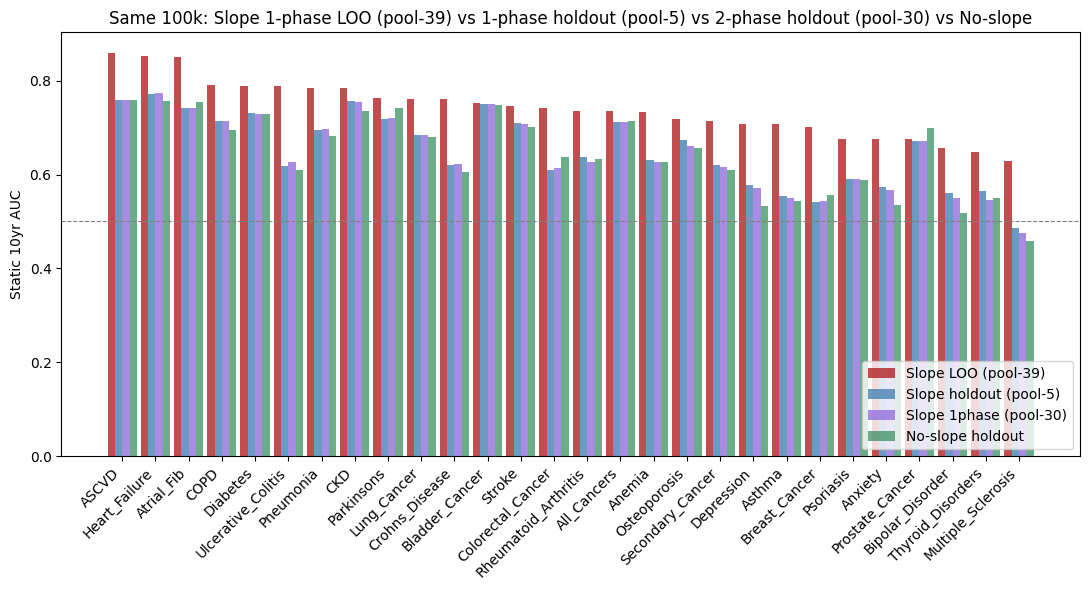

Saved: /Users/sarahurbut/aladynoulli2/claudefile/results_holdout_auc/slope_loo_vs_holdout_100k_comparison.pdf


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 6))
diseases = compare.index.tolist()
x = np.arange(len(diseases))
w = 0.22
ax.bar(x - 1.5*w, compare['auc_slope_loo_100k'], w, label='Slope LOO (pool-39)', color='firebrick', alpha=0.8)
ax.bar(x - 0.5*w, compare['auc_slope_holdout'], w, label='Slope holdout (pool-5)', color='steelblue', alpha=0.8)
if 'auc_slope_pool30_100k' in compare.columns:
    pool30_label = f'Slope {slope_pool30_label} (pool-30)' if slope_pool30_label else 'Slope (pool-30)'
    ax.bar(x + 0.5*w, compare['auc_slope_pool30_100k'], w, label=pool30_label, color='mediumpurple', alpha=0.8)
ax.bar(x + 1.5*w, compare['auc_noslope_holdout'], w, label='No-slope holdout', color='seagreen', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(diseases, rotation=45, ha='right')
ax.set_ylabel('Static 10yr AUC')
ax.set_title('Same 100k: Slope 1-phase LOO (pool-39) vs 1-phase holdout (pool-5) vs 2-phase holdout (pool-30) vs No-slope')
ax.legend(loc='lower right')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
out_path = RESULTS_HOLDOUT / 'slope_loo_vs_holdout_100k_comparison.pdf'
plt.savefig(out_path, bbox_inches='tight', dpi=150)
plt.show()
print(f'Saved: {out_path}')

In [ ]:
# Save comparison table
compare_out = RESULTS_HOLDOUT / 'slope_loo_vs_holdout_100k_comparison.csv'
compare.reset_index().to_csv(compare_out, index=False)
print(f'Saved: {compare_out}')

Saved: /Users/sarahurbut/aladynoulli2/claudefile/results_holdout_auc/slope_loo_vs_holdout_100k_comparison.csv
